In [3]:
import numpy as np
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
from skimage.morphology import opening
from skimage.morphology import disk, ball, cube
import skimage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
from aicsimageio import AICSImage
from skimage import filters as skfilters
from tifffile import imsave

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from itkwidgets import view 
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
# plt.rcParams["figure.figsize"] = [16, 12]

# dots
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

import cv2
import numpy as np

In [70]:
# read in the image 
filename = r"\\allen\aics\assay-dev\users\Sandi\mFISH\work-080823\TOP2A-raw-080823\TOP2A_007_002.tiff"
reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(1, 1, 51, 2048, 2048)


In [71]:
#####################
structure_channel = 0
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
# view(single_fluorescent_view(struct_img0))

In [72]:
################################
intensity_scaling_param = [5000] # original: 8000 current (V1-V4): 5000

large_sigma = 150 # v1&2: 5 v3: 500 v4: 150
small_sigma = -10 # V1&2: 1 v3:1 v4: -10

################################

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)


# smoothing with gaussian filter
large_gauss_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=large_sigma)
small_gauss_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=small_sigma)

intensity norm: min-max norm with upper bound 5000


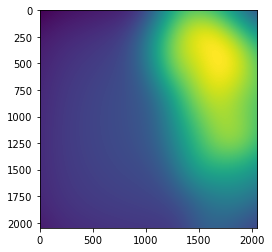

In [73]:
# view(single_fluorescent_view(_smooth))
plt.imshow(large_gauss_smooth[30])

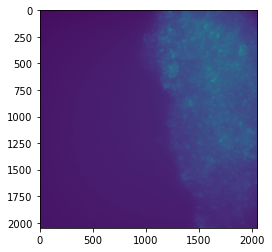

In [74]:
plt.imshow(small_gauss_smooth[30])

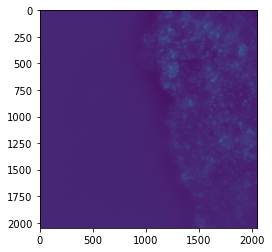

In [75]:
plt.imshow(small_gauss_smooth[30] - large_gauss_smooth[30])

In [76]:
correction = small_gauss_smooth - large_gauss_smooth
# view(single_fluorescent_view(correction))

In [77]:
# # smooth correction (only for v1 and v2)
# ################################
# intensity_scaling_param = [5000] # original: 8000 current: 5000

# gaussian_smoothing_sigma = 10
# ################################

# # intensity normalization
# struct_img = intensity_normalization(correction, scaling_param=intensity_scaling_param)

# # smoothing with gaussian filter
# final_smooth_correction = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

In [78]:
imsave("TOP2A_007_002_bc5.tiff", correction) 

<h4> Identifying Maxima Attempt 1 <h4>

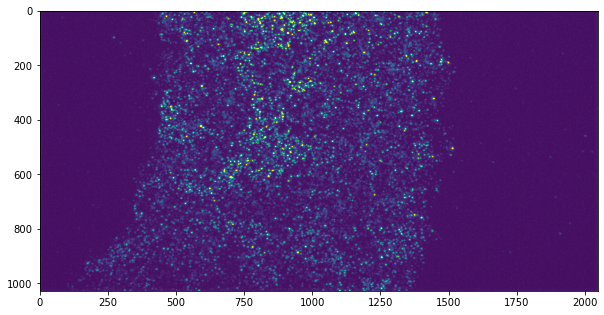

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(final_smooth_correction.max(axis=0), vmax=0.3)
plt.show()

In [21]:
def display_maxima_for_this_image(img, t):
    crop = img[:,1000:1100,1400:1500]
    spots = skimage.feature.peak_local_max(crop.max(axis=0), min_distance=3, threshold_abs=t)
    vmax = np.percentile(crop, 99.9)
    fig, ax = plt.subplots()
    ax.imshow(crop.max(axis=0), vmax=vmax, cmap="gray")
    ax.scatter(spots[:,1], spots[:,0], color="magenta", s=2)
    plt.show()
    return

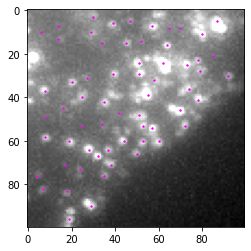

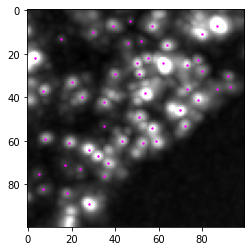

In [103]:
display_maxima_for_this_image(struct_img0, t=1200)
display_maxima_for_this_image(final_smooth_correction, t=0.08)

In [73]:
crop=final_smooth_correction[:,1000:1100,1400:1500]
crop = struct_img0[:,1000:1100,1400:1500]
print(crop.shape)

(51, 100, 100)


In [74]:
import skimage.io
import skimage.feature
import skimage.morphology
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

In [75]:
crop.max()

2735.0

In [85]:
spots = skimage.feature.peak_local_max(crop, min_distance = 3, threshold_abs=1300)

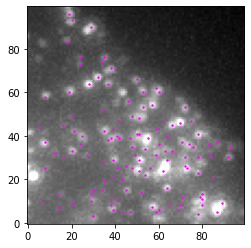

In [86]:
fig, ax = plt.subplots()
ax.imshow(crop.max(axis=0), vmax=2000, origin="lower", cmap="gray")
ax.scatter(spots[:,2], spots[:,1], color="magenta", s=2)
plt.show()

In [87]:
spots.shape

(123, 3)

In [ ]:
imsave("TOP2A_004_001_maxima1.tiff", spots) 

<h4> Attempt 2 <h4> 

In [11]:
# from: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_regional_maxima.html
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

image = img_as_float(final_smooth_correction)# Convert to float: Important for subtraction later which won't work with uint8
image = gaussian_filter(image, 10) # apply gaussian filter 

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

In [13]:
local_maxima = image-dilated
local_maxima.shape

(51, 2048, 2048)

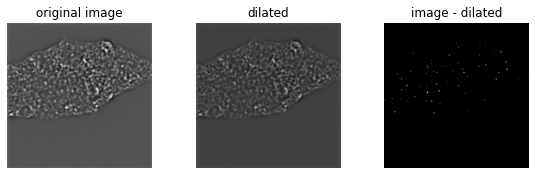

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image[30], cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated[30], vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image[30] - dilated[30], cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

In [15]:
imsave("TOP2A_004_001_maxima2.tiff", local_maxima) 